This nb tries to solve 1-d swe dam -break using examples from pyclaw

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from time import time

import sys
from clawpack import pyclaw
import h5py as h5
import pickle

In [ ]:
sys.path.append('/Users/rajvanmp/k@ust_learn/TF_PINNs')

In [ ]:
from PINNs import PINN
DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)
pi = tf.constant(np.pi,dtype=DTYPE)


In [ ]:
class domain():
    def __init__(self,lower,upper,DTYPE):
        self.lwb = tf.constant(lower,dtype=DTYPE)
        self.upb = tf.constant(upper,dtype=DTYPE)
        self.dim = tf.constant(len(lower))
        
    def sample_domain(self,n=10):
        x = []
        for i in range(self.dim):
            print(self.lwb[i],self.upb[i])
            x.append(tf.random.uniform((n,1),self.lwb[i],self.upb[i],dtype=DTYPE))
            
        return tf.squeeze(tf.stack(x,axis=1))
    
    def get_domain_points_lhs_1d(self,n=100):
    
        x_min = self.lwb[1].numpy()
        x_max = self.upb[1].numpy()
    
        t_min = self.lwb[0].numpy()
        t_max = self.upb[0].numpy()
    
        from scipy.stats import qmc
        sampler = qmc.LatinHypercube(d=2)
        sample = sampler.random(n)
        l_bounds = [t_min,x_min]
        u_bounds = [t_max,x_max]
        sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
        t = 1.0*sample_scaled[:,0]
        x = 1.0*sample_scaled[:,1]
    
    
    
        t = tf.constant(t,dtype=DTYPE)
        x = tf.constant(x,dtype=DTYPE)
    
        return tf.stack((t,x),axis=1)


In [ ]:
def load_psi_hdf5(file_name,n,use_zeldo=1):
    f = h5.File(file_name,"r")
    keys = list(f.keys())
    if use_zeldo:
        psi = f["psi_zeldo"]
    else:
        psi = f["psi"]
        
    psi = psi[:,0]+1j*psi[:,1]
    psi = np.reshape(psi,(n,n,n))
        
    print("Psi shape",psi.shape,psi.dtype)
    
    return psi

def Hfunc(a,omega_m0,a0=1.0):
    return( np.sqrt(omega_m0*(a0/a)*(a0/a)*(a0/a) + (1.0 - omega_m0))    )

In [ ]:
N = 1024

L = 1.0
dx = tf.constant(L/N,dtype=DTYPE)
xi = np.fft.fftfreq(N)*N*2*np.pi/L
xi2 = (xi*xi)

c_unit = 2.99
hbar_unit = 6.582
pc_unit = 3.086
h = 0.67
m_alpha = 0.175
omega_m0 = 0.3
ai = 0.0078125
    
kppa = c_unit*c_unit*hbar_unit*h*0.00001/(m_alpha*pc_unit)
#psi_ini = load_psi_hdf5("/Users/rajvanmp/station_X/pyGP_fields/test_fdm_dt/dc_128_dc_theta_psi_zeldo.hdf5",128,1)
plt.plot(xi)

In [ ]:
def get_1dfrom3d(psi_i,along_axis=2,i0=20,i1=20):
    if along_axis==2:
        psi_ini = psi_i[i0,i1,:]
    if along_axis==1:
        psi_ini = psi_i[i0,:,i1]
    if along_axis==0:
        psi_ini = psi_i[:,i0,i1]
    
    psi_ini_r = np.real(psi_ini)
    psi_ini_i = np.imag(psi_ini)

    u2 = np.square(np.abs(psi_ini))
    vrhs = 0.5*(u2-np.mean(u2))/kppa
    dlt = (u2-np.mean(u2))/(3.0*omega_m0)
    vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
    vrhsft[0] = 0.0+0.0*1j
    V = (np.fft.ifftn(vrhsft,vrhsft.shape))/(ai*ai*Hfunc(ai,omega_m0));
    
    psiV = np.stack([psi_ini_r,psi_ini_i,V],axis=-1)
    
    print(psi_ini_r.shape,psi_ini_i.shape,V.shape,psiV.shape)
    
    
    
    x = tf.linspace(tf.constant(0.0,dtype=DTYPE),L,N)
    t = 0.0*tf.ones_like(x)
    
    d_ini = tf.stack([t,x],axis=-1)
    
    return d_ini,tf.constant(psiV,dtype=DTYPE)
    

def get_prd_on_ini(n,x_i,f_i):
    nby2= int(n/2.0)
    print("nby2",nby2)
    i1 = tf.random.uniform(shape=[nby2,],minval=-N,maxval=-1,dtype=tf.dtypes.int64)
    ig1 = ((N-1+i1)+N)%N
    i1f = tf.cast(i1,dtype=DTYPE)
    x1 = 0.0+i1f*dx
    f1 = tf.gather(f_i,ig1)
    
    
    i2 = tf.random.uniform(shape=[nby2,],minval=1,maxval=N-1,dtype=tf.dtypes.int64)
    i2f = tf.cast(i2,dtype=DTYPE)
    x2 = L+i2f*dx
    f2 = tf.gather(f_i,i2)
    
    x = tf.concat((x1,x2),axis=0)
    t = 0.0*tf.ones_like(x)
    f = tf.concat((f1,f2),axis=0)
    
    
    d = tf.stack((t,x),axis=-1)
    
    #print(i1.shape,x1.shape)
    #print(i2.shape,x2.shape)
    print(x.shape,d.shape)
    #plt.plot(x1)
    #plt.plot(x2)
    return d,f

def get_prd_dom(dom,n):
    a = tf.random.uniform((n,), dom.lwb[0], dom.upb[0], dtype=DTYPE)
    x = tf.random.uniform((n,), dom.lwb[1], dom.upb[1], dtype=DTYPE)
    brnli = tf.keras.backend.random_bernoulli((n,), 0.5, dtype=DTYPE)
    x2 = x + dom.upb[1]*brnli - (1.0-brnli)*dom.upb[1]
    print(dom.upb[1])
    return tf.stack((a,x,x2),axis=-1)
    

In [ ]:
lower = (ai,0.0)
upper = (1.0,L)
dom = domain(lower,upper,DTYPE=DTYPE)
dom_bnds = [lower,upper]


x_prd =  get_prd_dom(dom,128)

x_dom = dom.get_domain_points_lhs_1d(n=1000)



In [ ]:
def pk(k,mu=0.0,sig = 10.5):
    return tf.exp(-tf.square((k-mu)/sig))

def ini_del(dom,n,pk,sigk):
    x = np.linspace(dom.lwb[1].numpy(),dom.upb[1].numpy(),n)
    mu = 0.0*np.ones([n,])
    sig = 0.01*np.ones([n,])
    u = np.random.normal(mu,sig)
    fu = np.fft.fftn(u,u.shape)
    
    kfac = np.sqrt(pk(xi,sig=sigk))
    fu = fu*kfac
    fu[0]=0.0+0.0j
    
    ifu =  np.real(np.fft.ifftn(fu,fu.shape))
    ifu = 0.01*ifu/np.max(ifu)
    
    plt.plot(u,"b")
    plt.plot(ifu,"r")
    print(np.sum(ifu),np.mean(u))
    
    return ifu,np.square(kfac)

    
iu,kf = ini_del(dom,N,pk,10.0)

def ini_psiFromdel(ini_del,om,ai):
    psi_r = np.sqrt(1.0+ini_del)
    psi_r = np.sqrt(3.0*om)*psi_r
    psi_i = tf.zeros_like(psi_r)
    
    u2 = np.square(psi_r)+np.square(psi_i)
    vrhs = 0.5*(u2-np.mean(u2))/kppa
    dlt = (u2-np.mean(u2))/(3.0*om)
    vrhsft = -np.fft.fftn(vrhs,vrhs.shape)/xi2
    vrhsft[0] = 0.0+0.0*1j
    V = (np.fft.ifftn(vrhsft,vrhsft.shape))/(ai*ai*Hfunc(ai,om));
    
    psiV = np.stack([psi_r,psi_i,V],axis=-1)
    
    print(psi_r.shape,psi_i.shape,V.shape,psiV.shape)
    
    
    
    x = tf.linspace(tf.constant(0.0,dtype=DTYPE),L,N)
    t = 0.0*tf.ones_like(x)
    
    d_ini = tf.stack([t,x],axis=-1)
    
    return d_ini,tf.constant(psiV,dtype=DTYPE)
    
    

def plot_pk(u,pk):
    fu = np.fft.fftn(u,u.shape)
    fu2 = np.square(np.abs(fu))
    pkk = pk(xi)
    
    #plt.plot(xi,fu2,"r")
    #plt.plot(xi,pkk,"b")
    
plot_pk(iu,pk)

In [ ]:
plt.plot(x_prd[:,1]-x_prd[:,2],"r*")


In [ ]:
from PINNs import PINN

dlta = tf.constant([1e-6],dtype=DTYPE)


        

        



        
        
class SP1(PINN):
    def __init__(self,dom_bounds,out_scales,out_dim,prob_coef=None,DTYPE='float32'):
        super().__init__(dom_bounds,out_dim,prob_coef,DTYPE)
        self.omega_m0 = tf.constant(prob_coef[0],dtype=DTYPE)
        self.fmin = tf.constant(out_scales[0],dtype=DTYPE)
        self.fmax = tf.constant(out_scales[1],dtype=DTYPE)
        
    def Hfunc(self,a,a0=1.0):
        return( tf.sqrt(self.omega_m0*(a0/a)*(a0/a)*(a0/a) + (1.0 - self.omega_m0))    )   

    
    def periodic(self,dom_points):
        a,x1,x2 = dom_points[:,0:1],dom_points[:,1:2],dom_points[:,2:3]
        f1 = self.model(tf.stack((a[:,0],x1[:,0]),axis=1),training=True)
        f2 = self.model(tf.stack((a[:,0],x2[:,0]),axis=1),training=True)
        
        return f1-f2
    
    def diff_eqn(self,dom_points,a0=1.0):
        a,x = dom_points[:,0:1],dom_points[:,1:2]
        H = self.Hfunc(a)
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(a)
            tape.watch(x)
        
            f = self.model(tf.stack((a[:,0],x[:,0]),axis=1),training=True)
            
            psi_rl = f[:,0:1]
            psi_im = f[:,1:2]
            V = f[:,2:3]
            
            dx_psi_rl = tape.gradient(psi_rl,x)
            dx_psi_im = tape.gradient(psi_im,x)
            dx_V = tape.gradient(V,x)
            
         
            
        dxx_psi_rl = tape.gradient(dx_psi_rl,x)
        dxx_psi_im = tape.gradient(dx_psi_im,x)
        dxx_V = tape.gradient(dx_V,x)
        
        da_psi_rl = tape.gradient(psi_rl,a)
        da_psi_im = tape.gradient(psi_im,a)
        
        rhs_rl = -0.5*kppa*dxx_psi_im/(a*a*a*H) + V*psi_im/(a*a*a*H)
        rhs_im =  0.5*kppa*dxx_psi_rl/(a*a*a*H) - V*psi_rl/(a*a*a*H)
        rhs_V = 0.5*(tf.square(psi_im)+tf.square(psi_rl) - 3.0*self.omega_m0)/kppa

        del tape
        
        eqn1 = da_psi_rl-rhs_rl
        eqn2 = da_psi_im-rhs_im
        eqn3 = dxx_V - rhs_V 
        #print(eqn1.shape,eqn2.shape)
        return tf.concat([eqn1,eqn2,eqn3],axis=1)  
    
    
    def compute_loss(self,dom_points,bndry_points,f_bndry,prd_dom):
        
        diff = self.diff_eqn(dom_points)
        diff_loss = tf.reduce_mean(tf.square(diff))
        
        #prd = self.periodic(prd_dom)
        #prd_loss = tf.reduce_mean(tf.square(prd))
    
        f_pred = self.model(bndry_points, training=True)
        bndry_loss = tf.reduce_mean(tf.square(f_pred-f_bndry))
    
        return bndry_loss+diff_loss,diff_loss/(bndry_loss+diff_loss)
    
    
    
    
    def get_loss_grads(self,dom_points,bndry_points,f_bndry,prd_dom):
        
        
       
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
        
            
            loss,diff_to_bndry = self.compute_loss(dom_points,bndry_points,f_bndry,prd_dom)
            
        
        grds = tape.gradient(loss,self.model.trainable_variables)
        
        del tape
        
        return loss,grds,diff_to_bndry
    
    
    @tf.function
    def train_step(self,dom_points,bndry_points,f_bndry,prd_dom):
        loss,grds,diff_to_bndry = self.get_loss_grads(dom_points,bndry_points,f_bndry,prd_dom)
        self.optim.apply_gradients(zip(grds, self.model.trainable_variables))
    
        return loss,diff_to_bndry
    
    
    def train(self,dom_points,bndry_points,f_bndry,prd_dom,n_epochs = 5000):
        
       	losses = []
        loss_min=tf.constant(1e6,dtype=self.DTYPE)
        param_best = self.model.get_weights()
        t0 = time()
        for i in range(n_epochs):
            loss,diff_to_loss = self.train_step(dom_points,bndry_points,f_bndry,prd_dom)
            losses.append(loss)
    
            if i%50==0:
                print('It {:05d}: loss = {:10.8e}  diff_2_loss = {}'.format(i,loss,diff_to_loss))
            if loss<loss_min:
                loss_min=loss
                param_best = self.model.get_weights()
        print("Best loss is ",loss_min)
        return losses,param_best
    
    def dyn_train(self,dom_points,bndry_points,f_bndry,n_epochs = 5000,dmn_n=5000):
        
        losses = []
        loss_min=tf.constant(1e6,dtype=self.DTYPE)
        param_best = self.model.get_weights()
        t0 = time()
        for i in range(n_epochs):
            if(i%100==0):
                dom_points=get_domain_points_lhs(dom,n=dmn_n)
                print("Sampling @ ",i)
            
            loss,diff_to_bndry = self.train_step(dom_points,bndry_points,f_bndry)
            losses.append(loss)
    
            if i%50==0:
                print('It {:05d}: loss = {:10.8e}  ratio = {}'.format(i,loss,diff_to_bndry))
            if loss<loss_min:
                loss_min=loss
                param_best = self.model.get_weights()
        print("Best loss is ",loss_min)
        return losses,param_best
        

 
    
   

In [ ]:
#Beq.model.compile(loss='mse',optimizer=optim1)

In [ ]:
def train_for_sig(sigk):
    
    
    ini_d,pkval = ini_del(dom,N,pk,sigk)

    
    x_i,f_i = ini_psiFromdel(ini_d,omega_m0,ai)
    x_b,f_b = get_prd_on_ini(N,x_i,f_i)

    print(x_i.shape,x_i.shape,f_i.shape,f_b.shape)

    x_bndry = tf.concat((x_i,x_b),axis=0)
    f_bndry = tf.concat((f_i,f_b),axis=0)



#x_dom = tf.stack((t,x),axis=1)
#x_dom = dom.sample_domain(4000)
    f_bndry_max = tf.reduce_max(f_bndry,axis=0)+tf.constant([0.0,1.0,0.0],dtype=DTYPE)

    f_bndry_min = tf.reduce_min(f_bndry,axis=0)

    f_bndry_norm = 2.0*(f_bndry-f_bndry_min)/(f_bndry_max-f_bndry_min)-1.0

    out_scales = [f_bndry_min,f_bndry_max]
    print("Out,",out_scales)
    
    omg =  np.array([omega_m0])#np.array([0.01/np.pi])##

    sp = SP1(dom_bnds,out_scales,3,omg,DTYPE)
    sp.model = sp.make_model(6,no_of_neu=40,act="tanh")
    #sp.model.summary()
    
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1500,3000,8000],[1e-3,1e-4,5e-5,1e-5])
    #lr = 0.001
# Choose the optimizer
    optim1 = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    sp.model.compile(loss="mse",optimizer=optim1)
    
    h=sp.model.fit(x_bndry,f_bndry_norm,epochs=1,verbose=0)
    
    min_loss = min(h.history["loss"])
    print(h.history)
    
    return {"sig":sigk,"min_loss":min_loss,"weights":sp.model.get_weights(),"ini_delta":ini_d,"pk":pkval}
    

In [3]:
sig_l = [10.0,50.0,150.0,200.0,250,300.0]
#slist = {}
#for sig in sig_l:
#    slist.update({str(sig):train_for_sig(sig)})

In [10]:
import pickle
with open('saved_slist2_6x20.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [14]:
mls_lst= []
slst = []
sig_keys = loaded_dict.keys()
for i in sig_keys:
    s = float(i)
    mls_lst.append(loaded_dict[i]["min_loss"])
    slst.append(s)


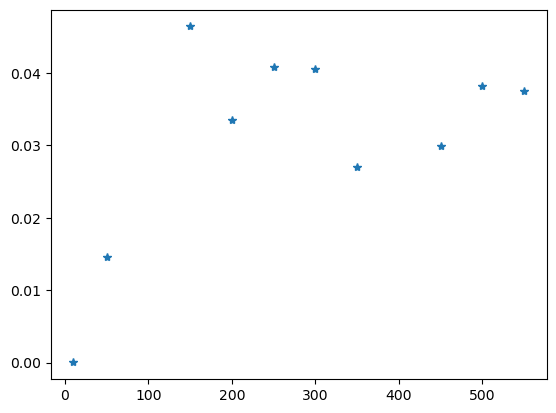

In [15]:
plt.plot(slst,mls_lst,"*")